In [28]:
import torch
import torchvision
from matplotlib import pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from sklearn.metrics import ConfusionMatrixDisplay
import torch.optim as optim
from sklearn.model_selection import train_test_split
import os

plt.style.use("fivethirtyeight")

# Przygotowanie danych

In [ ]:
!unzip "/content//train.zip"

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
device

device(type='cuda')

In [32]:
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = ImageFolder("/content/train", transform=train_transform)


In [33]:
classes = dataset.classes
len(classes)

31

In [34]:
data_labels = np.array([label for image, label in dataset.imgs])
class_labels, class_counts = np.unique(data_labels, return_counts=True)

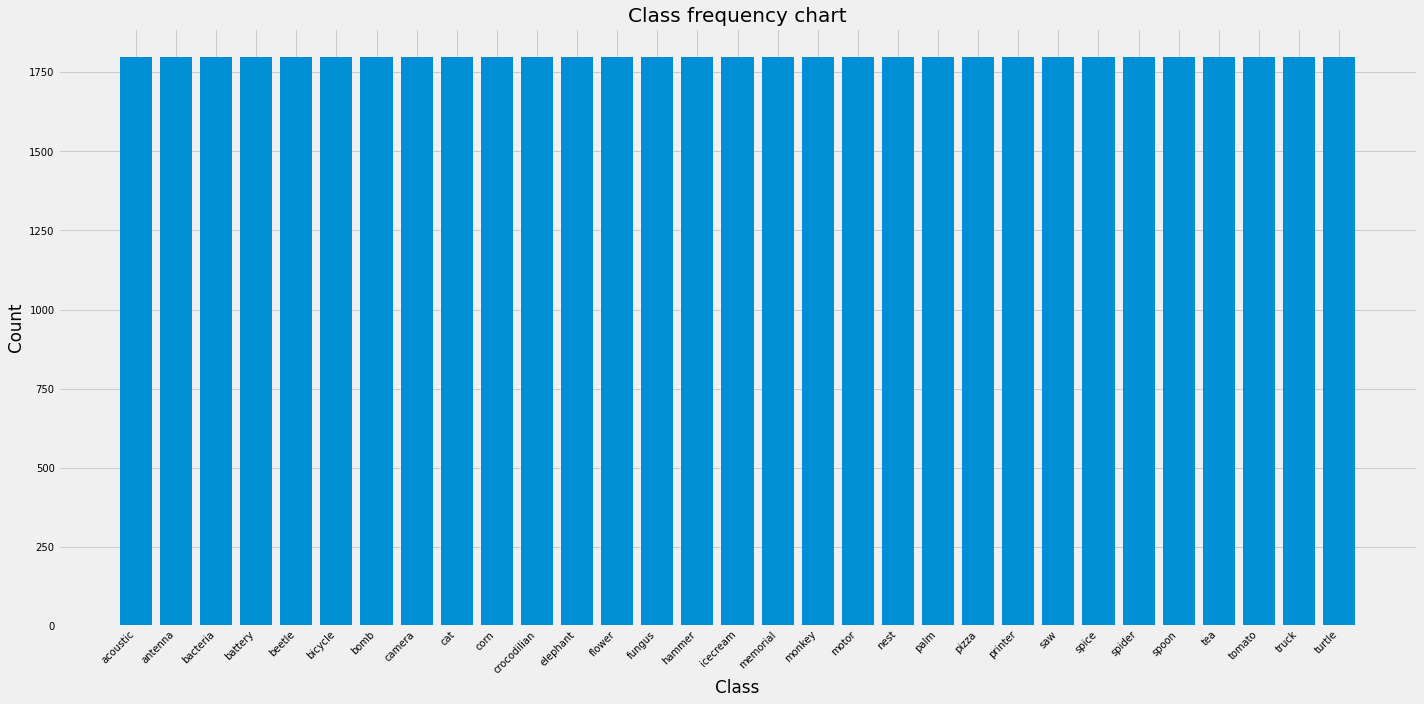

In [35]:
fig, ax = plt.subplots(1)
fig.set_size_inches(20, 10)

ax.bar(classes, class_counts)

ax.tick_params(labelsize=10)
fig.autofmt_xdate(rotation=45)
ax.set_title("Class frequency chart", fontsize=20)
ax.set_xlabel("Class")
ax.set_ylabel("Count")
fig.tight_layout()


In [36]:
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=2)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=2)

# Model

In [37]:
class HamsterNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Warstwa konwolucyjna
        self.convs = nn.Sequential(
            DeepHamsterLayer(in_channels=3, out_channels=32),
            DeepHamsterDreamLayer(in_channels=32, out_channels=64),
            DeepHamsterLayer(in_channels=64, out_channels=128),
            DeepHamsterDreamLayer(in_channels=128, out_channels=192),
            DeepHamsterLayer(in_channels=192, out_channels=256)
        )

        # Warstwa gęsta
        self.dense = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(6400, 4000),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4000),

            nn.Dropout(p=0.5),
            nn.Linear(4000, 500),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(500),

            nn.Dropout(p=0.5),
            nn.Linear(500, 50)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.convs(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dense(x)
        return x


class DeepHamsterLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, max_pool_kernel_size=2):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=max_pool_kernel_size)
        )

    def forward(self, x):
        return self.layers(x)


class DeepHamsterDreamLayer(nn.Module):
    """Simplified inception module"""
    def __init__(self, in_channels, out_channels):
        super().__init__()

        if out_channels % 2 != 0:
            raise ValueError(f"Out channels={out_channels} must be even number")

        hidden_out_channels = out_channels // 2

        self.conv1x1 = nn.Conv2d(in_channels=in_channels, out_channels=hidden_out_channels, kernel_size=1, stride=1, padding=0, bias=True)
        self.conv3x3 = nn.Conv2d(in_channels=in_channels, out_channels=hidden_out_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x_1x1 = self.conv1x1(x)
        x_3x3 = self.conv3x3(x)
        
        x = torch.cat([x_1x1, x_3x3], 1)
        x = self.relu(x)
        x = self.batchnorm(x)

        return x


In [38]:
def eval_on_train():
  model.eval()

  correct = 0
  total = 0
  with torch.no_grad():
      for data in train_loader:
          images, labels = data
          images = images.to(device)
          outputs = model(images).cpu()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the training images: %d %%' % (
      100 * correct / total))

In [39]:
def eval_on_validation():
  model.eval()

  correct = 0
  total = 0
  with torch.no_grad():
      for data in validation_loader:
          images, labels = data
          images = images.to(device)
          outputs = model(images).cpu()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the validation images: %d %%' % (
      100 * correct / total))

In [40]:
model = HamsterNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [41]:
# if os.path.isfile('model_state.csv'):
#     model.load_state_dict(torch.load('model_state.csv'))
n_epochs = 10
for epoch in range(n_epochs):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('[%d/%d] loss: %.3f' %
          (epoch+1 , n_epochs, running_loss))    
    eval_on_train()
    eval_on_validation()

print('Finished Training')
torch.save(model.state_dict(), 'model_state.csv')

[1/10] loss: 1933.818
Accuracy of the network on the training images: 45 %
Accuracy of the network on the validation images: 43 %
[2/10] loss: 1320.025
Accuracy of the network on the training images: 58 %
Accuracy of the network on the validation images: 56 %
[3/10] loss: 1090.121
Accuracy of the network on the training images: 64 %
Accuracy of the network on the validation images: 60 %
[4/10] loss: 948.382
Accuracy of the network on the training images: 68 %
Accuracy of the network on the validation images: 63 %
[5/10] loss: 853.509
Accuracy of the network on the training images: 75 %
Accuracy of the network on the validation images: 68 %
[6/10] loss: 770.551
Accuracy of the network on the training images: 74 %
Accuracy of the network on the validation images: 66 %
[7/10] loss: 715.787
Accuracy of the network on the training images: 80 %
Accuracy of the network on the validation images: 70 %
[8/10] loss: 685.501
Accuracy of the network on the training images: 83 %
Accuracy of the netw

# Ocena modelu

In [42]:
eval_on_train()

Accuracy of the network on the training images: 86 %


In [43]:
eval_on_validation()

Accuracy of the network on the validation images: 72 %


In [44]:
model.eval()

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

all_preds = []
all_labels = []

# again no gradients needed
with torch.no_grad():
    for data in validation_loader:
        images, labels = data    
        images = images.to(device)
        outputs = model(images).cpu()   
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        
        all_preds.extend([classes[label] for label in predictions])
        all_labels.extend([classes[label] for label in labels])

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class acoustic is: 53.2 %
Accuracy for class antenna is: 66.1 %
Accuracy for class bacteria is: 63.3 %
Accuracy for class battery is: 63.8 %
Accuracy for class beetle is: 76.6 %
Accuracy for class bicycle is: 82.1 %
Accuracy for class bomb  is: 70.2 %
Accuracy for class camera is: 79.9 %
Accuracy for class cat   is: 76.3 %
Accuracy for class corn  is: 58.0 %
Accuracy for class crocodilian is: 70.1 %
Accuracy for class elephant is: 87.0 %
Accuracy for class flower is: 91.2 %
Accuracy for class fungus is: 79.8 %
Accuracy for class hammer is: 72.2 %
Accuracy for class icecream is: 60.6 %
Accuracy for class memorial is: 77.5 %
Accuracy for class monkey is: 73.9 %
Accuracy for class motor is: 68.8 %
Accuracy for class nest  is: 56.6 %
Accuracy for class palm  is: 81.4 %
Accuracy for class pizza is: 90.8 %
Accuracy for class printer is: 65.1 %
Accuracy for class saw   is: 77.5 %
Accuracy for class spice is: 60.9 %
Accuracy for class spider is: 73.0 %
Accuracy for class spoon is:

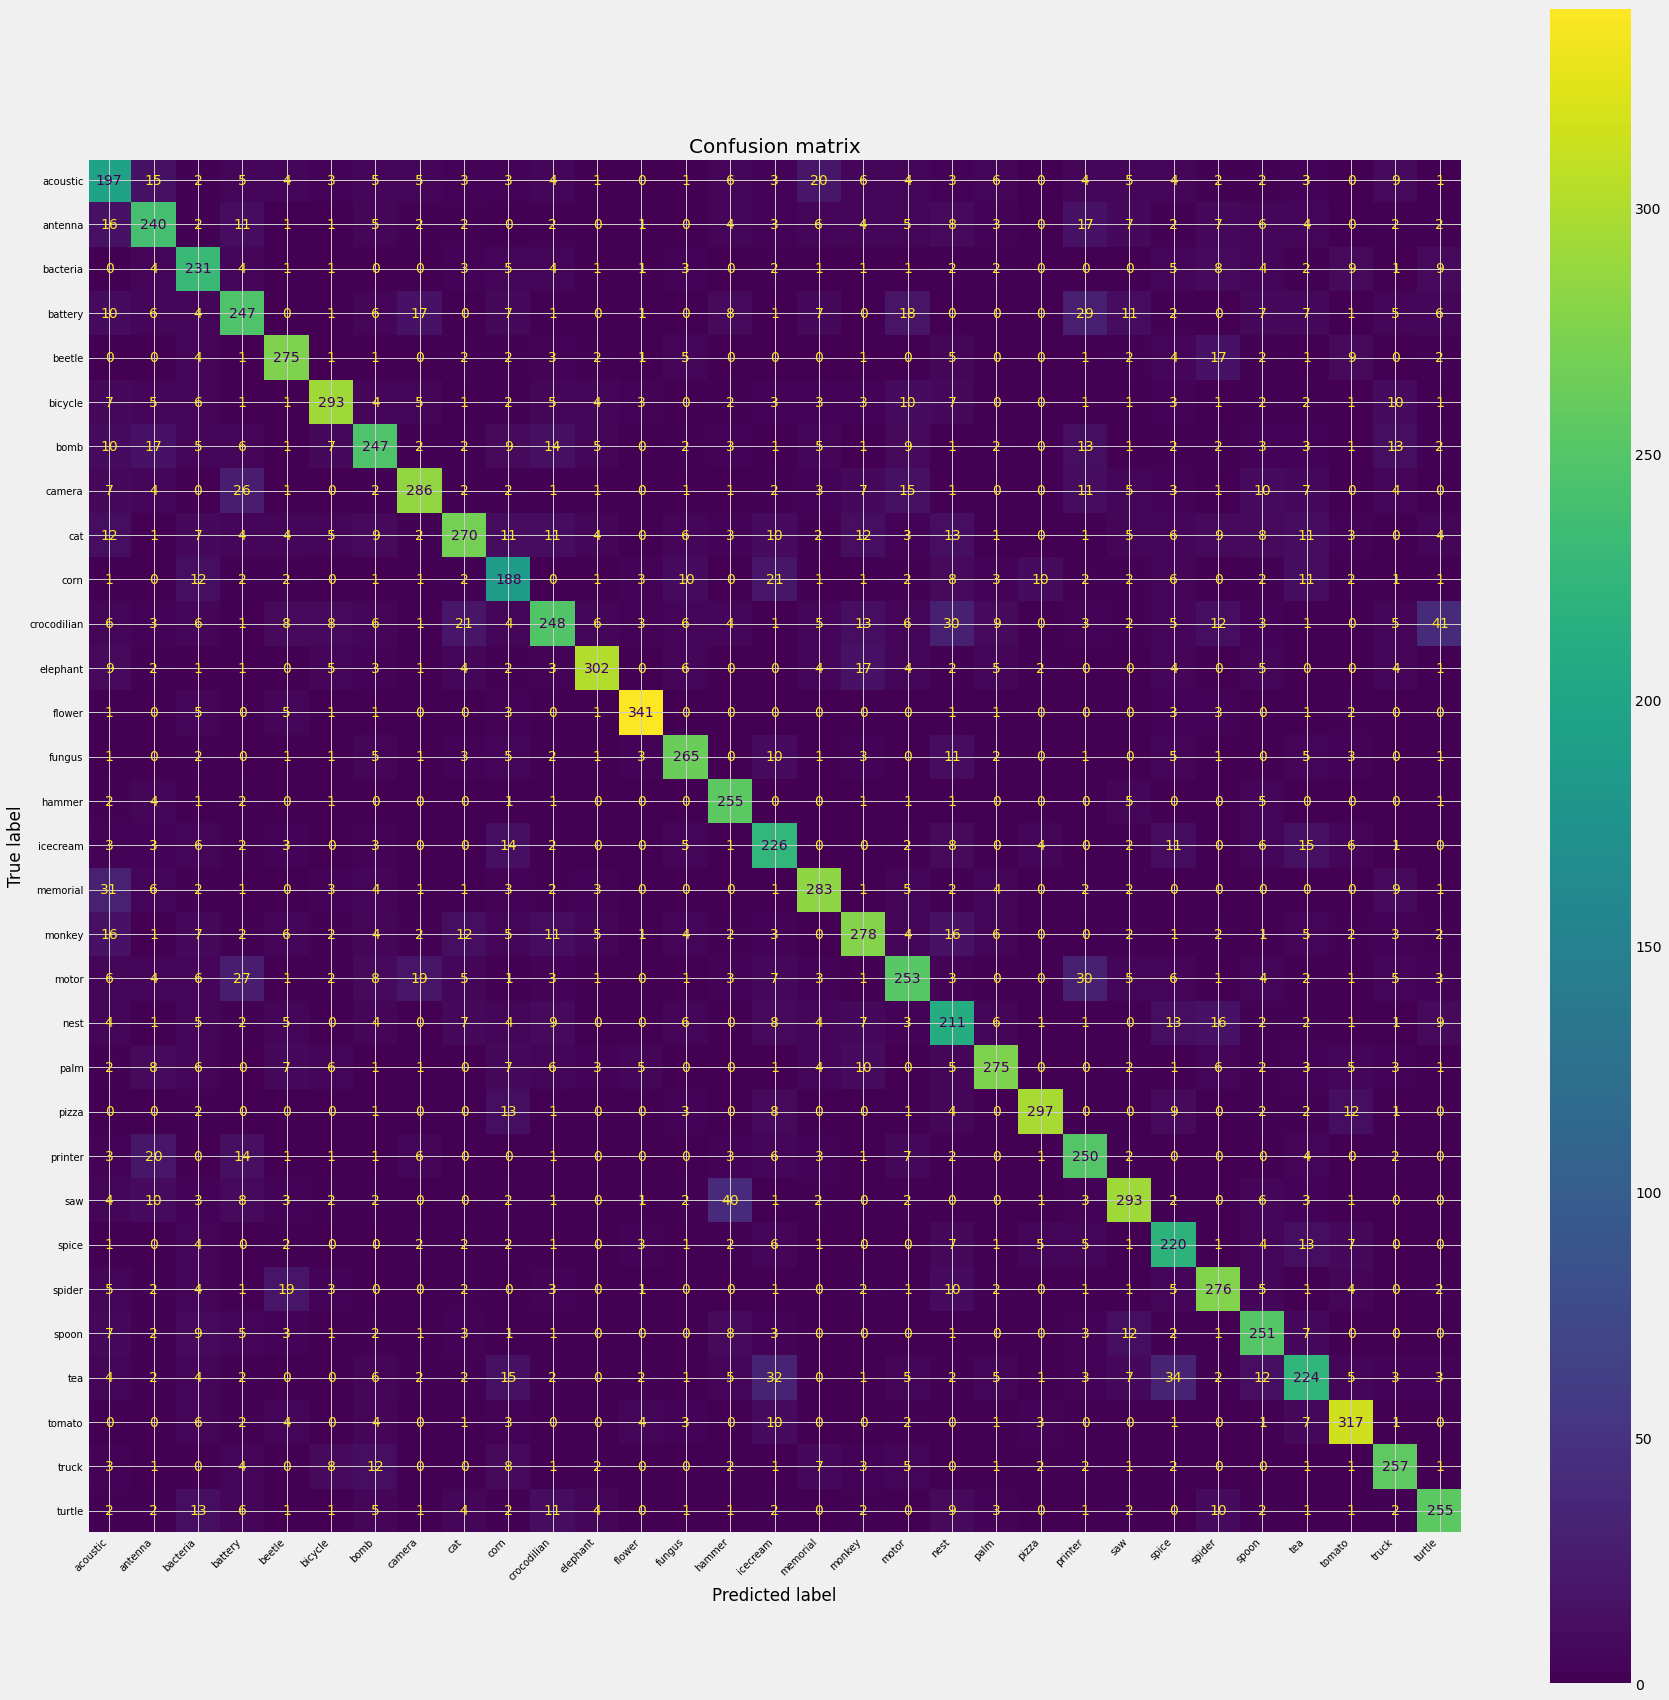

In [45]:
fig, ax = plt.subplots(1)
fig.set_size_inches(25, 25)
ConfusionMatrixDisplay.from_predictions(all_preds, all_labels, ax=ax)
ax.tick_params(labelsize=10)
fig.autofmt_xdate(rotation=45)
ax.set_title("Confusion matrix", fontsize=20)
fig.tight_layout()
